# Hotel Booking Demand : Possibility of Cancel

# Business Problem & Data Understanding

## Business Problem 

**Contex**<br>
Sebuah hotel di *Portugal* ingin mengetahui apakah sebuah hotel booking akan di *Canceled* atau tidak, Hotel ini ingin mengetahui apakah sebuah **Booking** akan berlanjut atau akan berakhir di *Cancel*, hal ini dapat membantu Hotel untuk mengingkatkan *revenue* karena jika sebuah booking akan berakhir *cancel*, hal itu bisa di alihkan kepada *Customer* yang lebih berpotensi menginap. 

Target: `is_canceled`

0 : Tidak melakukan cancelation

1 : Melakukan Cancelation

**Problem Statement**<br>

Jika menerima booking secara keseluruhan akan berpotensi adanya customer yang *cancel*, walaupun hal ini tidak memakan biaya, tapi hal ini sangat mempengaruhi hilangnnya potensi *revenue*.

Perusahaan ingin memaksimalkan *revenue* dengan meminimalisirkan potensi *cancel*, hal ini juga dilakukan agar perusahaan akan lebih fokus memperbanyak jumlah penginap semaksimal mungkin.

**Goals**

Dari *Problem Statement* diatas, perusahaan ingin bisa memprediksi *behaviour* dari customer, yang berpotensi untuk *cancel* atau yang tetap menginap di hotel tersebut.

tentunya dengan mengetahui faktor apa yang sekiranya mempengaruhi hal ini terjadi, sehingga Hotel bisa lebih terfokus untuk menentukan apakah individu/kelompok mana yang berpotensi melakukan *cancel* atau tidak.

**Analytics approach**

Disini kita akan melakukan analisa data pada *customer behaviour* dalam melakukan booking di hotel, antara melakukan *cancel* atau tidak

Dengan analisa data ini, kita akan membangun model klasifikasi yang dapat membantu perusahaan dalam memprediksi apakah individu/kelompok ini akan melakukan *cancel* atau tidak

**Metrics Evaluation**

|Actual/Predicted| P | N |
|----------------|---|---|
|P|TP|FN
|N|FP|TN

**Type 1 Error FP (False Positive):**<br>
Memiliki konsekuensi kehilangan customer yang tidak cancel

**Type 2 Error FN (False Negative):**<br>
Memiliki konsekuensi dimana hotel mempertahankan customer yang akan cancel

Melihat konsekuensi diatas, hal yang ingin di capai yaitu membuatkan model yang dapat meningkatkan *revenue* setinggi mungkin, oleh karena itu kedua FP dan FN merupakan hal yang penting untuk diperhatikan

# Data Exploration

## Big Picture

Pertama-tama kita akan import library sesuai dengan kebutuhan

Lalu kita akan lihat data secara big picturenya

In [181]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer

# Evaluation Metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Resampling
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN

# Pipeline
from imblearn.pipeline import Pipeline # note: Untuk data imbalance harus menggunakan pipeline dari imblearn (Untuk memasukkan resampling)

# Report 
from sklearn.metrics import classification_report

# Tuning
import optuna 

# Saving model
import pickle

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [182]:
# Import Data 

df = pd.read_csv('data_hotel_booking_demand.csv')
display(df.head(),df.tail())
print('Data Size:\nBaris : {}\nKolom : {}'.format(df.shape[0],df.shape[1]))

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
83572,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1


Data Size:
Baris : 83573
Kolom : 11


Kita akan lihat info lebih detail

In [183]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [184]:
# describe pada data numerik dan object
display(df.describe(),df.describe(include=object))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


In [185]:
# Perbesar view
pd.set_option('display.max_colwidth', -1)

# data unique di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,country,162,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, nan, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, ...]"
1,market_segment,8,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


Dari eksplorasi diatas, beberapa detail bisa dilihat di table di bawah ini:

**Feature**

|Feature | Type | Deskripsi
|--------|------|----------
|`Country` |Object|Negara asal
|`market_segment` | Object | Segmentasi market
|`previous_cancellations`| Int | Jumlah cancel sebelumnya
|`booking_changes`|Int | Perubahan booking
|`deposit_type` |Object | Tipe deposit
|`days_in_waiting_list`|Int | Jumlah hari customer masuk kedalam waiting list
|`customer_type` |Object | Tipe booking dari customer
|`reserved_room_type`| Object | Tipe kamar
|`required_car_parking_spaces`|Int | Kebutuhan tempat parkir mobil
|`total_of_special_requests` |Int | Total permintaan khusus
|`is_canceled`|Int | Cancel atau tidak
       

Secara garis besar:

1. Data berukuran 83573 x 11, dimana ada 83573 baris dan 11 kolom
2. `Country`, `market_segment`, `deposit_type`, `customer_type` dan `reserved_room_type` merupakan tipe object
3. `previous_cancellations`, `booking_changes`, `days_in_waiting_list`, `required_car_parking_spaces`, `total_of_special_request` dan `is_canceled` merupakan bentuk integer

Selanjutnya kita akan melakukan data cleaning terlebih dahulu

## Data Cleaning

### Missing Value

Sekarang kita akan melihat kehadiran missing value pada dataset ini.

In [186]:
# Missing value
df.isna().sum()

country                        351
market_segment                 0  
previous_cancellations         0  
booking_changes                0  
deposit_type                   0  
days_in_waiting_list           0  
customer_type                  0  
reserved_room_type             0  
required_car_parking_spaces    0  
total_of_special_requests      0  
is_canceled                    0  
dtype: int64

Terlihat bahwa hanya country yang memiliki missing value, sekarang kita cek berapa persen kehilangan data tersebut

In [187]:
# Persentase missing value
print('Persentase missing value "Country": {}'.format(df['country'].isna().sum()/df.shape[0]))

Persentase missing value "Country": 0.004199921027125986


Ternyata persentase missing value dari country hanyalah 0.004% dimana hal itu sangat sedikit, oleh karena itu kita bisa melakukan penghapusan data (tidak dilakukan modus agar tidak ada kesalahpahaman)

In [188]:
# Drop pada missing value
df.dropna(axis=0,inplace=True)

In [189]:
# Missing value
df.isna().sum()

country                        0
market_segment                 0
previous_cancellations         0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
reserved_room_type             0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
dtype: int64

Sekarang *feature* `country` tidak lagi memiliki missing value

### Duplicates

In [190]:
# Cek duplicates
df[df.duplicated()].shape[0]

73138

Ternyata setelah memeriksa duplicates, terdapat bahwa lebih dari 70% data memiliki duplicates, hal ini cukup *challenging* dimana kalau kita melakukan drop duplicates maka data akan kehilangan informasi yang cukup banyak, dan kalau kita tetap *menginclude* data duplicate itu akan membuat data kita menjadi bias. oleh karena itu perlu ada **sensitivity analysis** dimana kita akan comparing performance dan juga evaluating performance dari data kita yang ada duplicates dan juga yang tidak ada duplicatesnya.

Sebelum terjun lebih dalam lagi, kita perlu mengetahui nature dari data yang menyebabkan terjadinya duplicates yang cukup banyak

In [191]:
# Membuat DataFrame dengan menambahkan kolom Duplicates untuk mengetahui total duplicate tiap baris
duplicates = df[df.duplicated(keep=False)]
df_duplicates = duplicates.groupby(duplicates.columns.tolist()).size().reset_index(name='Duplicates')
df_duplicates.sort_values(by='Duplicates', ascending=False).head(5)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,Duplicates
3643,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1,4080
3833,PRT,Offline TA/TO,0,0,Non Refund,0,Transient,A,0,0,1,1851
3609,PRT,Groups,0,0,No Deposit,0,Transient-Party,A,0,0,1,1047
3989,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,1,0,949
3988,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,0,1,797


Terlihat bahwa duplicatenya ada yang bisa melebihi 4000 dalam 1 row, kita akan analisa untuk selanjutnya

In [192]:
# Total Duplicate tiap variasi market segment
df_duplicates['market_segment'].value_counts()

Online TA        2355
Direct           832 
Offline TA/TO    772 
Groups           395 
Corporate        240 
Complementary    64  
Aviation         33  
Name: market_segment, dtype: int64

Setelah kita lihat `market_segment`nya terlihat bahwa duplicate tersebar disetiap market, namun hal yang perlu kita perhatikan disini adalah market segment selain **direct**, mengapa begitu? diketahui bahwa online/offline TA(Travel Agent), Groups, Corporate, Complementary, Aviation semua merupakan kumpulan yang kemungkinan memiliki kerjasama ataupun berlangganan kepada hotel tersebut. Dimana pada contohnya, sebuah perusahaan yang dinas ke portugal akan memesan untuk 500 kamar, dengan kebutuhan yang sama persis, ataupun travel agent yang memang mempromosikan hotel tersebut dengan spesifikasi yang selalu sama. 

Lalu bagaimana dengan yang direct? Setiap orang yang ingin menginap dihotel biasanya akan menghadapi receptionist secara langsung, dan terkadang kebutuhan orang tidaklah jauh berbeda, seperti ada yang hanya butuh penginapan dan ada juga yang ternyata butuh parkir dan hal itu sangat banyak di hadapi di perhotelan

Hal-hal ini bisa terjadi dan menunjukkan bahwa penginputan spesifikasi kamar merupakan inputan yang valid dan terjadi di real-world data. bisa dibilang dengan data ini, kita dapat mengasumsikan bahwa group/kelompok ini memang melakukan pemesanan bundling yang cukup banyak sesuai dengan kebutuhannya. Hal ini berbeda dengan istilah 'Dirty Data' yang dikatakan oleh [**Heller Consulting**](https://teamheller.com/wp-content/uploads/2014/04/cgbestprac_datahygiene.pdf) dimana dirty duplicate data artinya adalah hasil dari human error dan tidak ada artinya. sedangkan disini duplicate memiliki *reasonnya* masing-masing

Sekarang coba kita lihat dari `days_in_waiting_listnya`

In [193]:
# List segmen
segmen = list(df_duplicates['market_segment'].unique())
segmen

['Complementary',
 'Corporate',
 'Direct',
 'Offline TA/TO',
 'Online TA',
 'Groups',
 'Aviation']

In [194]:
# For loop untuk melihat secara lebih jelas 
days = []

for i in segmen:
    days_segment = list(df_duplicates[(df_duplicates['market_segment']==i)]['days_in_waiting_list'].unique())
    days.append(days_segment)

pd.DataFrame({'Market_Segment':segmen,'Unique Days':days})

,Market_Segment,Unique Days
0,Complementary,[0]
1,Corporate,"[0, 15]"
2,Direct,[0]
3,Offline TA/TO,"[0, 99, 80, 147, 162, 178, 223, 63, 33, 65, 17, 27, 43, 68, 69, 108, 215, 187, 38, 40, 44, 77, 111, 4, 207, 3, 48, 50, 56, 58, 59, 224, 16, 21, 24, 34, 35, 39, 41, 55, 60, 62, 70, 71, 79, 85, 91, 96, 101, 120, 160, 15, 19, 25, 28, 42, 46, 31]"
4,Online TA,[0]
5,Groups,"[0, 53, 176, 60, 47, 25, 34, 38, 48, 61, 236, 259, 330, 379, 6, 101, 125, 150, 58, 174, 75, 49, 50, 87, 98, 122, 5, 17, 18, 20, 22, 26, 31, 32, 39, 41, 44, 46, 57, 71, 93, 391, 9, 10, 21, 35, 40, 45, 14, 96]"
6,Aviation,[0]


Terlihat bahwa complementary, corporate, online TA dan Aviation memiliki sedikit unique value karena tendency dari kerjasama dengan hotel, lalu untuk Offline TA/TO dan Groups memiliki lebih banyak variasi hari, namun hal itu wajar saja karena Offline TA/TO dan Group tidak memiliki informasi terupdate maka akan memiliki hari-hari dimana mereka harus menunggu di waiting list. Dan tentunya Direct pasti memiliki 0 di waiting list karena secara langsung customer akan menghampiri hotel tersebut dan tidak akan menginap jika tidak ada room available. 

**NOTE :**

Tentunya, hal ini hanyalah spekulasi awal dari nature data hotel, dan hal ini belum bisa di buktikan kepastiannya, dikarenakan limited data dan juga feature yang memiliki tendency untuk terpilih secara bersamaan dengan feature2 lainnya. Oleh karena itu tentunya kita perlu penanganan dan pembuktian untuk status data ini. dikarenakan duplicates yang terlalu banyak (menghapusnya bisa berakibat hilang informasi), analisa ini perlu di lakukan. Dan dalam pembuktiannya kita akan melakukan **Sensitivity analysis**, dimana kita akan membandingkan performa dari data yang ada duplicatesnya dengan yang tidak memiliki duplicates, akan di bandingkan dengan Test set yang sama juga (Karena dalam real-world data repetisi atau kesamaan data dalam kasus ini sangat bisa terjadi) dan hal ini juga ditulis dalam jurnal dari [**Research Gate**](http://openjournal.unpam.ac.id/index.php/JTSI/article/view/4223/pdf). Penjelasan selanjutnya ada di bawah ini:

Pertama kita akan split dataset menjadi 2 macam 

1. df : Dataset original (memiliki duplicates)
2. df_no_dup : Dataset tanpa duplicates (tidak memiliki duplicates)

In [195]:
# membuat dataset no dup 
df_no_dup = df.drop_duplicates()

In [196]:
# Hasil dari duplicates yang di hapus dan original dataset 
display(df.head(),df_no_dup.head())
print('\n Ukuran dataset dengan duplicates:',df.shape)
print('\n Ukuran dataset tanpa duplicates:',df_no_dup.shape)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0



 Ukuran dataset dengan duplicates: (83222, 11)

 Ukuran dataset tanpa duplicates: (10084, 11)


Terlihat dimana dataset dengan duplicate mempunyai **83.222** baris sedangkan yang duplicatesnya sudah di remove memiliki **10.084** baris  

**NOTE**:

Untuk data splitting akan dilakukan pada tahap data splitting itu sendiri. yang nantinya akan dipisah menjadi:

1. x_train : x train dengan duplikat
2. y_train : y train dengan duplikat
3. x_test : x test dengan duplikat
4. y_test : y test dengan duplikat
5. x_train_no_dup : x train tanpa duplikat
6. y_train_no_dup : y train tanpa duplikat
7. x_test_no_dup : x test tanpa duplikat
8. y_test_no_dup : y test tanpa duplikat

Lalu nantinya akan dilakukan sensitivity analysis.

### Outliers

Dalam menangani outlier hanya `days_in_waiting_list` yang memiliki nilai discrete

pertama akan kita cek untuk hubungannya 

<Axes: >

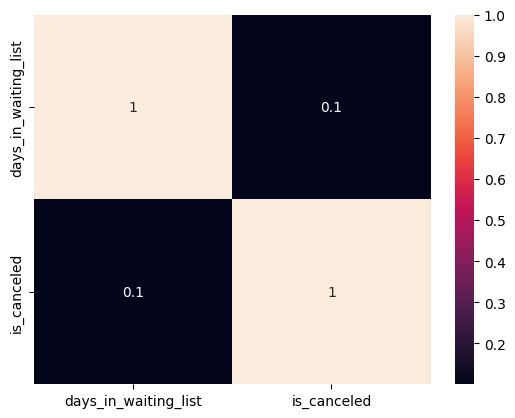

In [197]:
# Cek korelasi
sns.heatmap(df[['days_in_waiting_list','is_canceled']].corr('spearman'),annot=True)

terlihat bahwa hubungannya cukup lemah yaitu di positif 0.1 

sekarang kita akan lihat untuk is_canceled diatas 50, 100, 200 dan 300

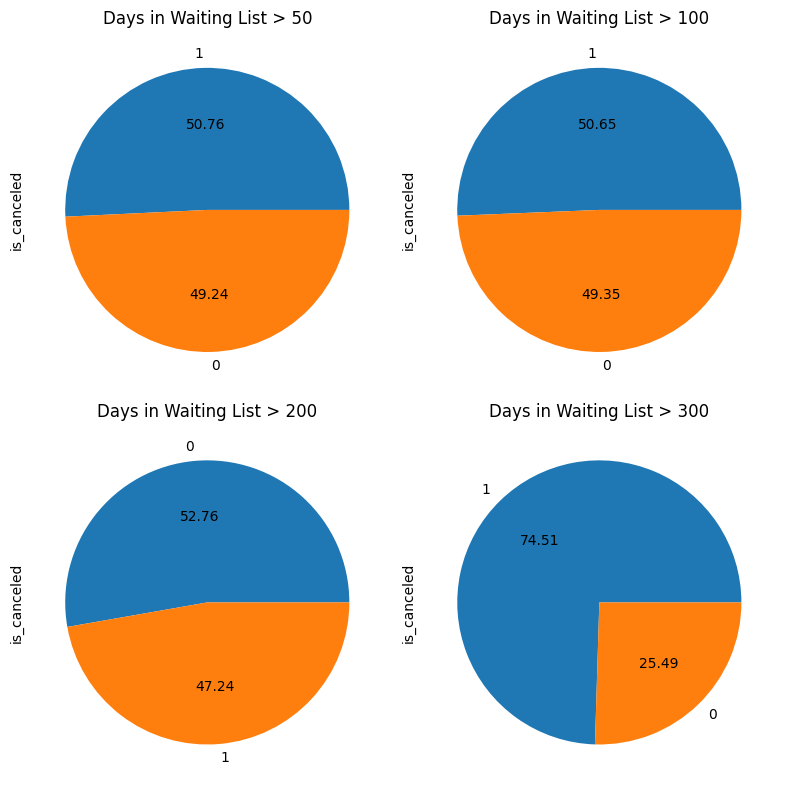

In [198]:
# membuatkan subplot berisikan pieplot
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# for loop untuk frekuensi days in waiting list
i_values = [50, 100, 200, 300]
for i, ax in zip(i_values, axs.flat):
    df[df['days_in_waiting_list'] > i]['is_canceled'].value_counts().plot.pie(autopct='%.2f', ax=ax)
    ax.set_title(f"Days in Waiting List > {i}")

plt.tight_layout()
plt.show()

Terlihat bahkan dalam waiting list lebih dari 300 hari masih ada yang tidak cancel, hal ini untuk menunjukkan bahwa penanganan outlier tidak diperlukan karena `days_in_waiting_list` pada outlier terbukti cukup merepresentasikan data dan tidak akan memperburuk model, dan jika kita akan menghapus outlier justru akan menimbulkan hilangnya informasi yang cukup penting (karena outlier justru menunjukkan adanya *unusual event*)

## Data Analysis

Dalam data analysis hanya dilakukan secara garis besar saja, dan diperlukan untuk mengetahui **nature** dari dataset 

In [199]:
# grouping by market segment
grouping_ms = pd.DataFrame(df.groupby('market_segment')['is_canceled'].count())
grouping_ms.reset_index(inplace=True)
grouping_ms

,market_segment,is_canceled
0,Aviation,165
1,Complementary,506
2,Corporate,3668
3,Direct,8776
4,Groups,13718
5,Offline TA/TO,16980
6,Online TA,39408
7,Undefined,1


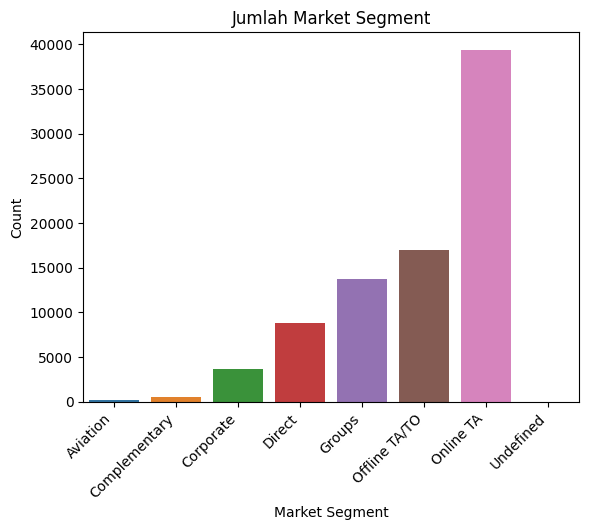

In [200]:
# membuatkan barplotnya
sns.barplot(x='market_segment', y='is_canceled', data=grouping_ms)
plt.title('Jumlah Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# show plot
plt.show()

Dilihat market segement yang paling banyak ada pada Online TA, sedangkan undifined yang paling kecil (hanya 1)

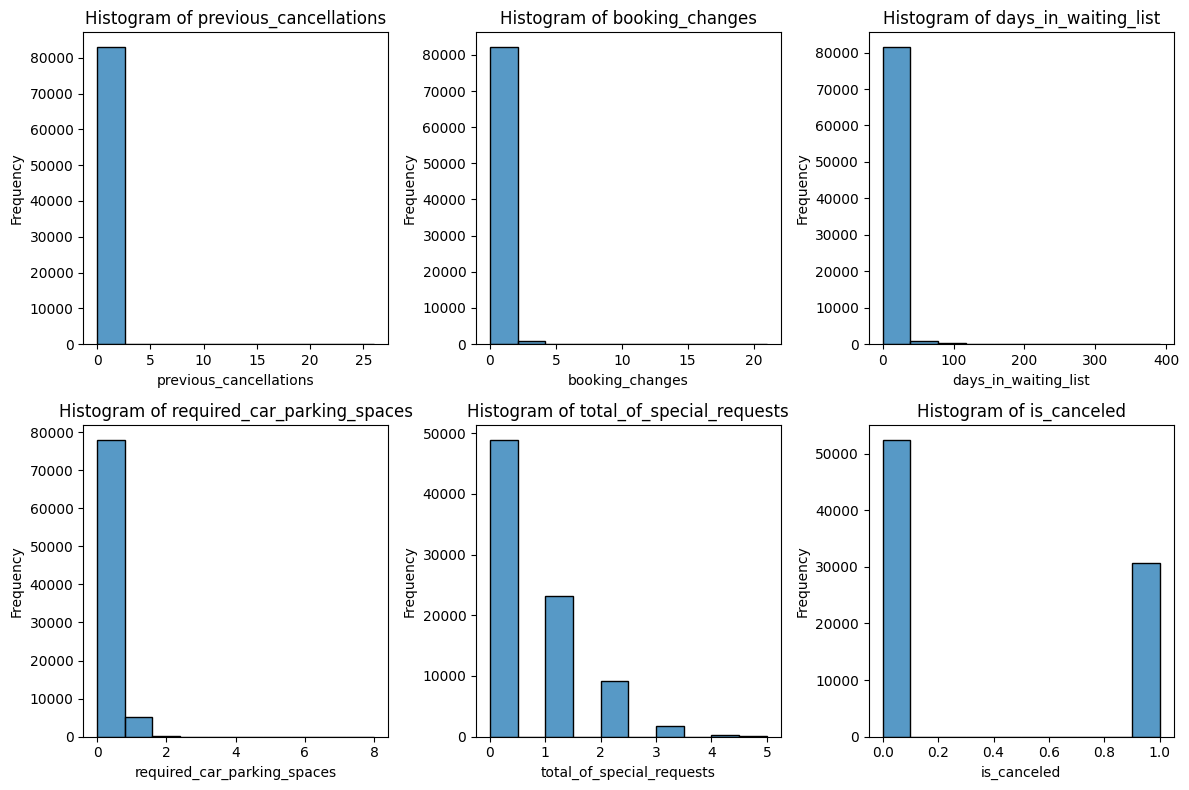

In [201]:
# membuat list dari kolom integer
df_int = ['previous_cancellations', 'booking_changes', 'days_in_waiting_list',
          'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled']

# membuat grid 2x3 subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop over kolom integer dan plot histogram di setiap subplot
for i, col in enumerate(df_int):
    sns.histplot(df[col], bins=10, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'Histogram of {col}')
    axs[i//3, i%3].set_xlabel(col)
    axs[i//3, i%3].set_ylabel('Frequency')

# mengatur spacing antar subplots
plt.tight_layout()
plt.show()

Dari distribusi diatas, kebanyakan dari feature memiliki bar yang tinggi di dekat angka 0

Sekarang kita akan lihat bagaimana proporsi dari target kita yaitu `is_canceled`

<Axes: ylabel='is_canceled'>

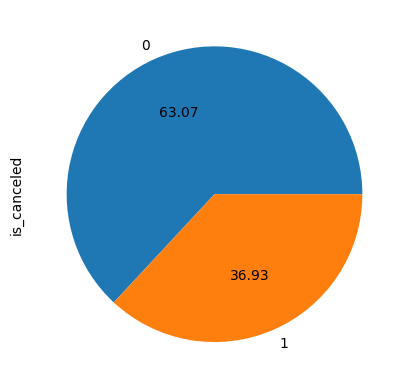

In [202]:
# Pieplot proporsi dari target variable
df['is_canceled'].value_counts().plot.pie(autopct = '%.2f')

Terlihat bahwa dataset ini memiliki data yang Imbalance dimana sekitar 63:37 untuk proporsi dari targetnya

# Data Preprocessing

## Feature Engineering

Pada tahapan ini, kita akan melakukan Feature Engineering, dimana tahapan ini merupakan cara untuk merubah atau memproses data menjadi data yang representatif dan juga berarti untuk dijalankan kedalam model machine learning

In [203]:
display(df.head())
print('Ukuran data:',df.shape)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Ukuran data: (83222, 11)


Berdasarkan penjelasan singkat dari feature engineering diatas, kita dapat menyimpulkan bahwa:

1. pada *feature* `country` melakukan transformasi data menggunakan *binary encoding*, hal ini dilakukan karena `country` memiliki category yang cukup banyak lebih dari 100, jadi pendekatan menggunakan *binary encoding* merupakan pendekatan yang tepat, dan juga karena tidak memiliki urutan maka binary encoding adalah pendekatan yang tepat.

2. Melakukan transformasi juga pada feature `market_segment` dan `reserved_room_type` menggunakan *binary encoding*, hal ini juga serupa dengan `country` karena kedua feature ini memiliki category yang banyak, dan juga tidak memiliki urutan.

3. Melakukan transformasi pada feature `deposit_type` dan `customer_type` dengan *one hot encoding*, dimana jumlahnya juga masih sedikit maka masih *manageable*, dan tentunya hal ini dilakukan juga karena kedua feature ini tidak memiliki urutan

4. Untuk seluruh feature dengan tipe *integer* tidak akan kita berikan treatment, dikarenakan angkanya yang masih dalam jangkauan dan juga sudah sesuai/representatif.

5. karena target `is_canceled` merupakan integer antara 1 dan 0, kita tidak akan memberikan treatment apapun karena sudah sesuai untuk kebutuhan pembuatan model.

Hal pertama yang kita lakukan adalah melakukan onehot encoding dan juga binary encoding, hal ini dilakukan pada feature-feature khusus seperti di bawah ini: 

In [204]:
# definisikan onehot encoder kedalam variable
onehot = OneHotEncoder(drop='first') #lakukan drop first agar tidak menjadi bias
# variable yang akan dilakukan transformasi one hot
onehot_var = ['deposit_type','customer_type']

# definisikan binary encoder dan juga imputasi dengan pipeline
binary = ce.BinaryEncoder()

# variable yang akan di imputasi dan di transformasi 
binary_var = ['country','market_segment','reserved_room_type']

In [205]:
# lakukan transformer kolom 
transformer = ColumnTransformer([
    ('onehot',onehot,onehot_var),
    ('binary',binary,binary_var)
], remainder='passthrough') #tidak lupa untuk melakukan passthrough

**Note:**
**Transformer ini akan selalu di pakai kedepannya**

Dari sini terlihat bahwa onehot encoding dan binary encoding sudah di masukkan kedalam variable transformer, hal ini tentunya untuk mengotomasikan perubahan dari dataset ini, dan tidak lupa untuk melakukan passthrough kepada feature yang tidak memerlukan perubahan

## Data Splitting

Dari nature data yang diatas hal yang kita dapat bahwa banyaknya terdapat **duplicates**, dan hal ini cukup challenging, karena kita harus melakukan perbandingan atau **sesitivity analysis**, oleh karena itu kita akan melakukan splitting data menjadi 8 bagian:
1. x_train : x train dengan duplikat
2. y_train : y train dengan duplikat
3. x_train_no_dup : x train tanpa duplikat
4. y_train_no_dup : y train tanpa duplikat
5. x_test_no_dup : x test tanpa duplikat
6. y_test_no_dup : y test tanpa duplikat
7. x_test : x test dengan duplikat
8. y_test : y test dengan duplikat


Sekarang kita akan melakukan splitting data, dimulai dari x/y train duplikat dan x/y test

In [206]:
display(df.shape,df_no_dup.shape)

(83222, 11)

(10084, 11)

In [207]:
# x = independent
# y = dependent (target)
x = df.drop('is_canceled', axis=1)
y = df['is_canceled']

# x = independent no dup
# y = dependent no dup (target)
x_no_dup = df_no_dup.drop('is_canceled', axis=1)
y_no_dup = df_no_dup['is_canceled']

Kita akan definisikan terlebih dahulu antara train dan test

In [208]:
# splitting data Train+validation and Test
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=100)

In [209]:
# Splitting juga pada data yang no dup
x_train_no_dup, x_test_no_dup, y_train_no_dup, y_test_no_dup = train_test_split(x_no_dup, y_no_dup, stratify=y_no_dup, test_size=0.2, random_state=100)

In [210]:
# cek size 
print('x_train :',x_train.shape)
print('x_test :',x_test.shape)

print('\nx_train_no_dup :',x_train_no_dup.shape)
print('x_test_no_dup :',x_test_no_dup.shape)


x_train : (66577, 10)
x_test : (16645, 10)

x_train_no_dup : (8067, 10)
x_test_no_dup : (2017, 10)


Terlihat seperti yang sudah di sampaikan bahwa *drawbacks* dari menghilangkan duplicate pada dataset ini adalah hilangnnya banyak informasi, hal ini terlihat dari ukuran data train yang turun secara drastis dari 66577 menjadi 8067

## Preprocessing Result

Untuk kedepannya preprocessing akan menggunakan pipeline, namun disini hanya untuk melihat hasil dari preprocessingnnya terlebih dahulu, kita ingin lihat transformasi data kita apakah sudah sesuai atau belum

In [211]:
# fit & transform hanya pada x_train
x_train_prep = pd.DataFrame(transformer.fit_transform(x_train)) # kita pakai 1 contoh saja dengan x_train yang ada duplikatnya

Namun sampai tahapan ini, nama kolom masih hilang, seperti contoh dibawah ini

In [212]:
x_train_prep.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


Oleh karena itu kita akan kembalikan namanya 

In [213]:
# mengambil nama kolom untuk dimasukkan kembali
# disimpan dalam variable onehot_name
onehot_name = list(transformer.transformers_[0][1].get_feature_names_out())

In [214]:
# mengambil nama dari binary encoder
# disimpan dalam variable binary_name
binary_name = list(transformer.transformers_[1][1].get_feature_names_out())

In [215]:
# hasil urutan penaaman
features = onehot_name + binary_name + ['previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']

In [216]:
# kita cek untuk ukuran kolomnya
print('Ukuran xtrain: {}'.format(x_train_prep.shape[1]))

Ukuran xtrain: 26


In [217]:
# Ukuran features
print('Ukuran features name: {}'.format(len(features)))

Ukuran features name: 26


Terlihat bahwa sudah memiliki ukuran yang sama, sekarang kita akan memasukkan kedalam nama kolomnya

In [218]:
# Memasukkan nama features kedalam data split
x_train_prep.columns = features

In [219]:
# Cek hasilnya
pd.options.display.max_columns = None
x_train_prep

,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,market_segment_0,market_segment_1,market_segment_2,market_segment_3,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,reserved_room_type_3,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66572,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
66573,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
66574,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
66575,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


terlihat proses preprocessing sudah berjalan dengan lancar, sekarang saatnya kita akan memasuki tahap modelling & evaluation

# Modelling & Evaluation

Pada tahap ini kita akan mulai melakukan modelling dengan beberapa algoritma untuk menyelesaikan masalah klasifikasi, dan juga melakukan evaluasi dari beberapa algoritma, hal ini dilakukan dengan melakukan cross validasi terlebih dahulu, baru kita akan melihat reportnya dengan melihat evaluasi dari test setnya, **dan tidak lupa juga kita akan melakukan komparasi hasil dengan duplikasi dan juga tanpa duplikasi**

Pertama kita akan definisikan tiap algoritmanya

## Algorithms

In [220]:
# membuatkan variable untuk setiap algorithm
logreg = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = GaussianNB()
knn = KNeighborsClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

## Model Benchmarking : K-Fold

Dalam model benchmarking *Evaluation Metrics* utama yang digunakan adalah **f1-score**<br>
hal ini dilakukan karena sesuai dengan goal atau tujuan dari penyelesaian permasalahan disini

### With duplicates

Hal pertama yang perlu kita test adalah melakukan cross-validasi dimana **duplicates** terdapat pada training data

In [221]:
# buat list of models yang akan di iterasikan untuk menjalankan cross-val
model = [logreg,dt,rf,nb,knn,xgb,lgbm]

# buat list kosong untuk menampung hasil yang nanti akan di compile kedalam dataframe
f1 = []
f1_std = []
roc_auc = []
roc_std = []
acc_scr = []
pre = []
rec = []

# iterasi dari variable model 
for alg in model:
    # SK-fold dengan 5 split
    skfold = StratifiedKFold(n_splits=5)
    # pipeline dengan transformer
    estimator = Pipeline([
    ('transformer',transformer),
    ('model',alg)
    ])
    # membuatkan cross val pada masing2 metrics
    model_f1 = cross_val_score(estimator, x_train,y_train,cv=skfold,scoring='f1')
    model_roc_auc = cross_val_score(estimator, x_train,y_train,cv=skfold,scoring='roc_auc')
    model_acc = cross_val_score(estimator, x_train,y_train,cv=skfold,scoring='accuracy')
    model_pre = cross_val_score(estimator, x_train,y_train,cv=skfold,scoring='precision')
    model_rec = cross_val_score(estimator, x_train,y_train,cv=skfold,scoring='recall')

    # memasukkan kedalam list kosong
    f1.append(model_f1.mean())
    f1_std.append(model_f1.std())
    roc_auc.append(model_roc_auc.mean())
    roc_std.append(model_roc_auc.std())
    acc_scr.append(model_acc.mean())
    pre.append(model_pre.mean())
    rec.append(model_rec.mean())

# hasil akan di masukkan kedalam dataframe agar lebih jelas 
model_comparison = pd.DataFrame({'model':['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','XGBoost','LightGBM'], 
                                'f1-score': f1,'std_f1': f1_std, 'roc_auc': roc_auc,'roc_std':roc_std,'Accuracy':acc_scr, 'Precision':pre, 
                                'Recall':rec})
# tampilkan hasilnya
model_comparison.set_index('model').sort_values(by='f1-score',ascending=False)

,f1-score,std_f1,roc_auc,roc_std,Accuracy,Precision,Recall
model,,,,,,,
LightGBM,0.728556,0.005566,0.891795,0.002096,0.810340,0.772631,0.689323
Random Forest,0.722385,0.006613,0.886460,0.002611,0.806420,0.768628,0.686272
Decision Tree,0.721229,0.007517,0.876275,0.002785,0.805083,0.764745,0.682815
XGBoost,0.720601,0.006255,0.891970,0.001857,0.810625,0.791635,0.661501
KNN,0.687596,0.003979,0.846490,0.003327,0.782658,0.733074,0.647875
Logistic Regression,0.649132,0.006773,0.850133,0.003028,0.778542,0.782142,0.554851
Naive Bayes,0.621622,0.010341,0.783653,0.003436,0.675580,0.555003,0.719138


Berdasarkan hasil cross-validasi yang dilakukan pada data train yang memiliki duplicate, hasil menunjukkan bahwa model LightGBM merupakan model yang paling tinggi f1-scorenya sebagai metrics utama, dan dapat dilihat juga kestabilan modelnya dari std dari f1 yang cukup baik.

terlihat juga bahwa roc_auc cukup tinggi dan juga akurasinya yang tinggi juga

Selanjutnya kita akan lihat untuk yang tanpa duplicate

### Without Duplicate

In [222]:
# buat list of models yang akan di iterasikan untuk menjalankan cross-val
model = [logreg,dt,rf,nb,knn,xgb,lgbm]

# buat list kosong untuk menampung hasil yang nanti akan di compile kedalam dataframe
f1 = []
f1_std = []
roc_auc = []
roc_std = []
acc_scr = []
pre = []
rec = []

# iterasi dari variable model 
for alg in model:
    # SK-fold dengan 5 split
    skfold = StratifiedKFold(n_splits=5)
    # pipeline dengan transformer
    estimator = Pipeline([
    ('transformer',transformer),
    ('model',alg)
    ])
    # membuatkan cross val pada masing2 metrics
    model_f1 = cross_val_score(estimator, x_train_no_dup,y_train_no_dup,cv=skfold,scoring='f1')
    model_roc_auc = cross_val_score(estimator, x_train_no_dup,y_train_no_dup,cv=skfold,scoring='roc_auc')
    model_acc = cross_val_score(estimator, x_train_no_dup,y_train_no_dup,cv=skfold,scoring='accuracy')
    model_pre = cross_val_score(estimator, x_train_no_dup,y_train_no_dup,cv=skfold,scoring='precision')
    model_rec = cross_val_score(estimator, x_train_no_dup,y_train_no_dup,cv=skfold,scoring='recall')

    # memasukkan kedalam list kosong
    f1.append(model_f1.mean())
    f1_std.append(model_f1.std())
    roc_auc.append(model_roc_auc.mean())
    roc_std.append(model_roc_auc.std())
    acc_scr.append(model_acc.mean())
    pre.append(model_pre.mean())
    rec.append(model_rec.mean())
    
# hasil akan di masukkan kedalam dataframe agar lebih jelas 
model_comparison_no_dup = pd.DataFrame({'model':['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','XGBoost','LightGBM'], 
                                'f1-score': f1,'std_f1': f1_std, 'roc_auc': roc_auc,'roc_std':roc_std,'Accuracy':acc_scr, 'Precision':pre, 
                                'Recall':rec})

# tampilkan hasilnya
model_comparison_no_dup.set_index('model').sort_values(by='f1-score',ascending=False)

,f1-score,std_f1,roc_auc,roc_std,Accuracy,Precision,Recall
model,,,,,,,
Naive Bayes,0.517246,0.025980,0.772186,0.015287,0.697647,0.435398,0.671962
XGBoost,0.411632,0.016398,0.818971,0.009209,0.776374,0.549418,0.329165
LightGBM,0.409900,0.013288,0.817826,0.008199,0.781332,0.572552,0.319763
KNN,0.342294,0.031356,0.680157,0.014660,0.733607,0.414252,0.292125
Logistic Regression,0.341149,0.026297,0.798580,0.012515,0.780217,0.594850,0.239941
Random Forest,0.298983,0.016374,0.697106,0.006535,0.695673,0.334244,0.279080
Decision Tree,0.289536,0.022950,0.550405,0.017385,0.672740,0.298896,0.277510


Ternyata jika kita menghilangkan duplicate, model yang terbaik adalah menggunakan Naive Bayes, dimana model ini bisa dibilang cukup jauh dari scoring f1nya, dimana disini hanya mendapatkan sekitar 0.51, dimana kalau duplicate tetap digunakan, dia bisa mencapai 0.72, dan dapat dilihat juga secara keseluruhan bahwa score lainnya seperti roc_auc dan accuracy berkurang jauh di keseluruhan model. kalau dilihat dari kestabilannya juga menunjukkan bahwa hasil tanpa duplikat ini kurang stabil dibandingkan dengan yang ada duplikatnya

Setelah kita membandingkan model, hal yang bisa diambil adalah:

1. dengan duplicate LGBM adalah model paling maximum performanya
2. tanpa duplicate Naive Bayes merupakan model paling maximum performanya
3. **dengan duplicate** secara keseluruhan semua model memiliki performa yang jauh lebih baik dibandingkan **tanpa duplicate**

Namun sebelum membuat konklusi, kita akan melakukan model benchmarking pada test set, dimana kalau sebelumnya kita hanya melakukan pada training dan validation saja. 

## Model Benchmarking : Test Set

Setelah melakukan cross-validasi kita akan melakukannya pada test set

### With duplicate

In [223]:
# Model 
model = [logreg,dt,rf,nb,knn,xgb,lgbm]
# list kosong untuk menampung metrics
pre = []
rec = []
f1S = []
acc = []
roc = []

# for loop pada model
for alg in model:
    
    # membuatkan pipeline
    estimator = Pipeline([
        ('transformer',transformer),
        ('model',alg)
    ])
    
    # fit data
    estimator.fit(x_train,y_train)
    
    # eval metrics
    y_pred = estimator.predict(x_test)
    pre_score = precision_score(y_test,y_pred)
    rec_score = recall_score(y_test,y_pred)
    f1_sscore = f1_score(y_test,y_pred)
    acc_score = accuracy_score(y_test,y_pred)
    roc_score = roc_auc_score(y_test,y_pred)
    
    # masukkan kedalam list kosong
    pre.append(pre_score)
    rec.append(rec_score)
    f1S.append(f1_sscore)
    acc.append(acc_score)
    roc.append(roc_score)

# buatkan dataframenya
model_test_comparison = pd.DataFrame({'model':['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','XGBoost','LightGBM'], 
                                'Precision': pre,'Recall': rec, 'f1-score': f1S,'Accuracy':acc,'ROC_AUC':roc})   

# tampilkan hasilnya
model_test_comparison.sort_values(by='f1-score',ascending=False) 

,model,Precision,Recall,f1-score,Accuracy,ROC_AUC
6,LightGBM,0.777182,0.707012,0.740438,0.816942,0.794161
2,Random Forest,0.769502,0.709289,0.738170,0.814178,0.792442
5,XGBoost,0.798193,0.675614,0.731806,0.817122,0.787798
1,Decision Tree,0.777943,0.679356,0.725315,0.809973,0.782905
4,KNN,0.726111,0.656418,0.689508,0.781676,0.755719
0,Logistic Regression,0.780979,0.555718,0.649368,0.778372,0.732231
3,Naive Bayes,0.581471,0.702456,0.636263,0.703394,0.703200


Pada test set menunjukkan bahwa LightGBM merupakan model terbaiknya juga

### Without duplicate

In [224]:
# Model 
model = [logreg,dt,rf,nb,knn,xgb,lgbm]
# list kosong untuk menampung metrics
pre = []
rec = []
f1S = []
acc = []
roc = []

# for loop pada model
for alg in model:
    # membuatkan pipeline
    estimator = Pipeline([
        ('transformer',transformer),
        ('model',alg)
    ])
    # fit data
    estimator.fit(x_train_no_dup,y_train_no_dup)

    # eval metrics
    y_pred_no_dup = estimator.predict(x_test_no_dup)
    pre_score = precision_score(y_test_no_dup,y_pred_no_dup)
    rec_score = recall_score(y_test_no_dup,y_pred_no_dup)
    f1_sscore = f1_score(y_test_no_dup,y_pred_no_dup)
    acc_score = accuracy_score(y_test_no_dup,y_pred_no_dup)
    roc_score = roc_auc_score(y_test_no_dup,y_pred_no_dup)
    # masukkan kedalam list kosong
    pre.append(pre_score)
    rec.append(rec_score)
    f1S.append(f1_sscore)
    acc.append(acc_score)
    roc.append(roc_score)
# buatkan dataframenya
model_test_comparison_no_dup = pd.DataFrame({'model':['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','XGBoost','LightGBM'], 
                                'Precision': pre,'Recall': rec, 'f1-score': f1S,'Accuracy':acc,'ROC_AUC':roc})    

# tampilkan hasilnya
model_test_comparison_no_dup.sort_values(by='f1-score',ascending=False)

,model,Precision,Recall,f1-score,Accuracy,ROC_AUC
3,Naive Bayes,0.461538,0.601253,0.522212,0.738721,0.691394
5,XGBoost,0.588462,0.319415,0.414073,0.785325,0.624922
6,LightGBM,0.618644,0.304802,0.408392,0.790283,0.623142
4,KNN,0.420420,0.292276,0.344828,0.736242,0.583394
0,Logistic Regression,0.586207,0.212944,0.312404,0.777392,0.583065
2,Random Forest,0.347709,0.269311,0.303529,0.706495,0.555982
1,Decision Tree,0.302730,0.254697,0.276644,0.683689,0.535996


Tanpa duplikat, menunjukkan bahwa model yang terbaik pada test set adalah LightGBM, hal ini menunjukkan bahwa adanya indikasi underfit pada proses cross validasi, selain itu, ini adalah dampak dari hilangnnya banyak data yang mengandung banyak informasi, oleh karena itu dapat dikonklusikan bahwa **menyertakan duplikat pada data** merupakan langkah yang terbaik.

## Cross Test 

### **Duplicate Train on No-Duplicate Test**

Karena cross-validasi pada duplikat memenangkan LGBM maka train duplikat akan menggunakan LGBM

In [225]:
# Model 
model = [lgbm]
# list kosong untuk menampung metrics
pre = []
rec = []
f1S = []
acc = []
roc = []

# for loop pada model
for alg in model:
    
    # membuatkan pipeline
    estimator = Pipeline([
        ('transformer',transformer),
        ('model',alg)
    ])
    
    # fit data
    estimator.fit(x_train,y_train)
    
    # eval metrics
    y_pred_no_dup = estimator.predict(x_test_no_dup)
    pre_score = precision_score(y_test_no_dup,y_pred_no_dup)
    rec_score = recall_score(y_test_no_dup,y_pred_no_dup)
    f1_sscore = f1_score(y_test_no_dup,y_pred_no_dup)
    acc_score = accuracy_score(y_test_no_dup,y_pred_no_dup)
    roc_score = roc_auc_score(y_test_no_dup,y_pred_no_dup)
    
    # masukkan kedalam list kosong
    pre.append(pre_score)
    rec.append(rec_score)
    f1S.append(f1_sscore)
    acc.append(acc_score)
    roc.append(roc_score)

# buatkan dataframenya
model_test_comparison_cross = pd.DataFrame({'model':['LightGBM'], 
                                'Precision': pre,'Recall': rec, 'f1-score': f1S,'Accuracy':acc,'ROC_AUC':roc})  
# tampilkan hasilnya
model_test_comparison_cross.sort_values(by='f1-score',ascending=False)

,model,Precision,Recall,f1-score,Accuracy,ROC_AUC
0,LightGBM,0.70082,0.356994,0.473029,0.811106,0.654765


### **No-Duplicate Train on Duplicate Test**

Karena cross-validasi pada no-duplikat memenangkan Naive Bayes maka train no-duplikat akan menggunakan Naive Bayes

In [226]:
# Model terpilih
model = [nb]
# list kosong untuk menampung metrics
pre = []
rec = []
f1S = []
acc = []
roc = []

# for loop pada model
for alg in model:
    
    # membuatkan pipeline
    estimator = Pipeline([
        ('transformer',transformer),
        ('model',alg)
    ])
    
    # fit data
    estimator.fit(x_train_no_dup,y_train_no_dup)
    
    # eval metrics
    y_pred = estimator.predict(x_test)
    pre_score = precision_score(y_test,y_pred)
    rec_score = recall_score(y_test,y_pred)
    f1_sscore = f1_score(y_test,y_pred)
    acc_score = accuracy_score(y_test,y_pred)
    roc_score = roc_auc_score(y_test,y_pred)
    
    # masukkan kedalam list kosong
    pre.append(pre_score)
    rec.append(rec_score)
    f1S.append(f1_sscore)
    acc.append(acc_score)
    roc.append(roc_score)

# buatkan dataframenya
model_test_comparison_cross_no_dup = pd.DataFrame({'model':['Naive Bayes'], 
                                'Precision': pre,'Recall': rec, 'f1-score': f1S,'Accuracy':acc,'ROC_AUC':roc})  
# tampilkan hasilnya
model_test_comparison_cross_no_dup.sort_values(by='f1-score',ascending=False)

,model,Precision,Recall,f1-score,Accuracy,ROC_AUC
0,Naive Bayes,0.540746,0.799902,0.645276,0.675218,0.701056


Overall Test Performance:

Test-On | Model	|Precision	|Recall	|F1-Score	|Accuracy	|ROC_AUC
-----|----------|-----------|-------|-----------|-----------|--------
Duplicates |LightGBM	|0.777182	|0.707012	|0.740438	|0.816942	|0.794161
Duplicates|Naive Bayes	|0.540746	|0.799902	|0.645276	|0.675218	|0.701056
No-Duplicates |LightGBM	|0.70082	|0.356994	|0.473029	|0.811106	|0.654765
No-Duplicates |Naive Bayes	|0.461538	|0.601253	|0.522212	|0.738721	|0.691394



Jadi berdasarkan table diatas ini, dimana dilakukan cross test dari model yang terpilih yaitu LightGBM dan Gaussian Naive Bayes, diketahui bahwa:

1. Dengan melakukan modelling pada test set duplikat, terlihat bahwa sudah sangat jelas LightGBM memiliki score yang jauh lebih baik dibandingkan Naive Bayes, dimana pastinya karena naive bayes menggunakan training data yang lebih sedikit, maka model kurang mempelajari pattern-pattern yang kompleks, dimana kalau LightGBM mentrainingkan keseluruhan (termasuk duplikat), dan berhasil menghasilkan score yang jauh lebih baik dari Naive Bayes 

2. Pada test selanjutnya adalah dengan melakukan modelling pada test set tanpa duplikat, disini terlihat bahwa Naive Bayes terlihat lebih unggul pada F1-Scorenya, namun secara overall, LightGBM tidak begitu buruk, walaupun F1-Scorenya cukup rendah (Tentu disebabkan oleh test set yang cukup kecil), Precisionnya bisa memiliki nilai yang tinggi, bahkan lebih tinggi dari naive bayes, dan juga Accuracy yang tinggi. Untuk ROC AUCnya tidak terlalu berbeda dengan Naive Bayes 

Dari Table diatas, bisa dibilang bahwa LightGBM adalah model yang lebih aman dan lebih stabil. Kita juga harus memperhatikan lagi permasalahan kita, Tentu saja real-live data bisa saja memproduksi duplikasi data, oleh karena itu pilihan yang lebih baik adalah tetap menggunakan Duplikat pada data train dan test, dan juga model yang digunakan adalah LightGBM 

Konklusi dari model benchmarking :
1. Duplikat dari data tetap digunakan karena merupakan informasi yang penting, dimana hal yang sama terjadi juga bisa terjadi di dunia nyata, dan juga dengan menghilangkan duplikat terlihat akan memberikan hasil yang jauh lebih buruk, dimana tidak ada cara lain selain menghapusnya, maka itu menciptakan *uncertainty*, **dimana merupakan salah satu alasan mengapa duplicates tetap digunakan.** (dikutip dari [sini](https://link.springer.com/article/10.1007/s00778-009-0161-2))

2. LightGBM merupakan algoritma yang terpilih pada saat model benchmarking diatas ini, dimana:
- LightGBM merupakan algoritma yang didasarkan dari tree-based model, dimana merupakan model non-parametric. ([kutipan](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/how-lightgbm-works.htm#:~:text=LightGBM%20is%20a%20gradient%20boosting,high%20performance%20with%20distributed%20systems.))
- LightGBM merupakan model yang dibilang lebih ringan dan lebih efektif dibandingkan dengan XGboost (Extreme Gradient Boosting)
- Salah satu feature terbaik dari LightGBM adalah EFB (Exclusive Feature Bundling, Lebih detail [disini](https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/)), dimana LightGBM akan melakukan bundling pada feature yang sudah di encoding dengan mengurangi dimensinya, hal ini tentu akan membantu dalam mempercepat training

## Resampling vs Without Resampling

Selanjutnya kita akan melakukan resampling pada dataset kita, dimana sudah tertera pada tahapand EDA, dimana dataset ini termasuk dataset yang **imbalance**, oleh karena itu per dilakukan penanganan pada data imbalance yaitu dengan resampling

Pada tahap ini dilakukan perbandingan untuk mendapatkan hasil yang paling optimal, antara 2 undersampling, 2 oversampling dan 1 combination

Berikut untuk mendefinisikannya:

In [253]:
# Undersampling strategy RandomUnderSampler & NearMiss
rus = RandomUnderSampler(sampling_strategy='not minority',random_state=100)
nm = NearMiss(sampling_strategy='not minority')
# Oversampling strategy RandomOverSampling & SMOTE
ros = RandomOverSampler(sampling_strategy='not majority',random_state=100)
smt = SMOTE(sampling_strategy='not majority',random_state=100)
# Combination SMOTEENN
smtnn = SMOTEENN(sampling_strategy='auto',random_state=100)
# Model & Skfold
model = lgb.LGBMClassifier()
skfold = StratifiedKFold(n_splits=5)

### Under Sampling

Pada tahapan ini, hanya untuk memperlihatkan perubahan dari undersampling yang dilakukan

#### RandomUnderSampling

In [227]:
# Melakukan fitting kepada 
x_train_rus, y_train_rus = rus.fit_resample(x_train_prep, y_train) # menggunakan prep karena sudah diubah oleh dengan encoding

In [228]:
# Awalnya
y_train.value_counts()

0    41992
1    24585
Name: is_canceled, dtype: int64

In [229]:
# setelah undersampling
y_train_rus.value_counts()

0    24585
1    24585
Name: is_canceled, dtype: int64

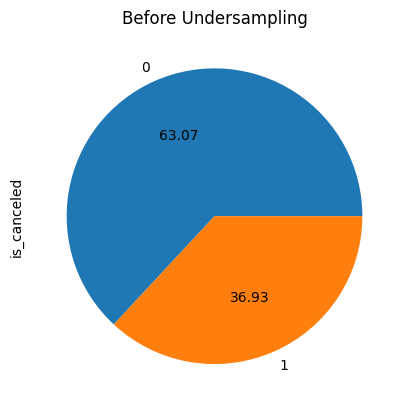

In [230]:
# piechart sebelum undersampling
y_train.value_counts().plot.pie(autopct = '%.2f')
plt.title('Before Undersampling')
plt.show()

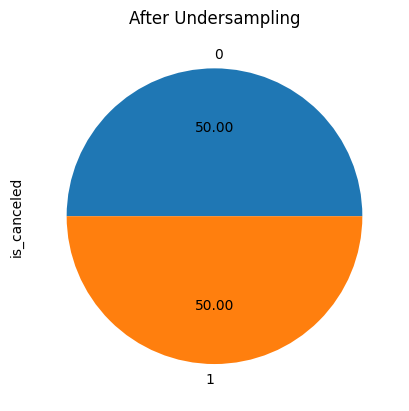

In [231]:
# piechart setelah undersampling
y_train_rus.value_counts().plot.pie(autopct = '%.2f')
plt.title('After Undersampling')
plt.show()

Terlihat bahwa setelah dilakukan RandomUnderSampling, maka kelas mayoritas akan mengikuti kelas minoritas

#### NearMiss

Selanjutnya masih undersampling, namun kali ini menggunakan NearMiss, hal ini juga dilakukan untuk menunjukkan bagaimana perubahannya

In [232]:
# Fit nearmiss 
x_train_nm, y_train_nm = nm.fit_resample(x_train_prep, y_train)

In [233]:
# awal data
y_train.value_counts()

0    41992
1    24585
Name: is_canceled, dtype: int64

In [234]:
# setelah undersampling dengan nearmiss
y_train_nm.value_counts()

0    24585
1    24585
Name: is_canceled, dtype: int64

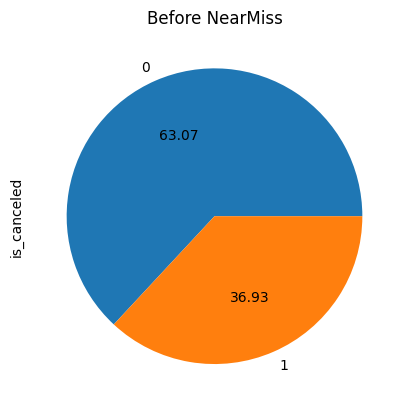

In [235]:
# Piechart sebelum
y_train.value_counts().plot.pie(autopct = '%.2f')
plt.title('Before NearMiss')
plt.show()

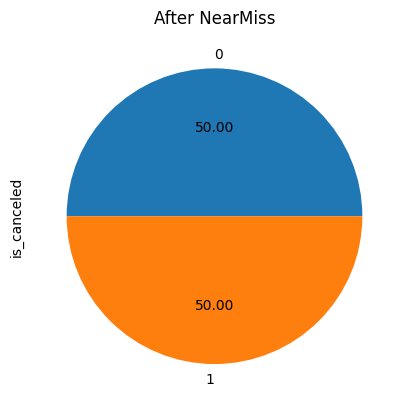

In [236]:
# piechart sesudah undersampling dengan nearmiss
y_train_nm.value_counts().plot.pie(autopct = '%.2f')
plt.title('After NearMiss')
plt.show()

Terlihat bahwa RUS dan NearMiss sama-sama memangkas majority class, namun yang membedakan adalah pilihannya dalam memangkas majority class tersebut

### Over Sampling

Selanjutnya adalah oversampling, disini juga sama hanya untuk menunjukkan bagaimana perubahannya

#### RandomOverSampling

In [237]:
# Fit ROS 
x_train_ros, y_train_ros = ros.fit_resample(x_train_prep, y_train)

In [238]:
# Awalan data
y_train.value_counts()

0    41992
1    24585
Name: is_canceled, dtype: int64

In [239]:
# Setelah resampling dengan ROS
y_train_ros.value_counts()

0    41992
1    41992
Name: is_canceled, dtype: int64

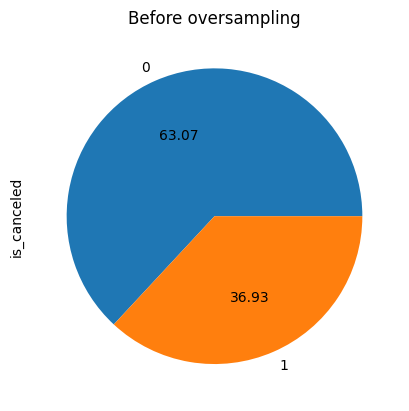

In [240]:
# Piechart sebelum 
y_train.value_counts().plot.pie(autopct = '%.2f')
plt.title('Before oversampling')
plt.show()

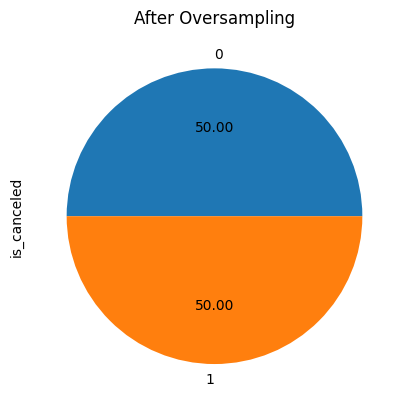

In [241]:
# piechart sesudah ROS 
y_train_ros.value_counts().plot.pie(autopct = '%.2f')
plt.title('After Oversampling')
plt.show()

Berbeda dengan undersampling, dimana oversampling dengan ROS menambahkan minority class, sehingga memiliki nilai yang sama dengan majority class

#### SMOTE

Hal ini juga sama untuk SMOTE, dimana merupakan metode oversampling

In [242]:
# fit SMOTE
x_train_smt, y_train_smt = smt.fit_resample(x_train_prep, y_train)

In [243]:
# Awal data
y_train.value_counts()

0    41992
1    24585
Name: is_canceled, dtype: int64

In [244]:
# Setelah oversampling dengan SMOTE
y_train_smt.value_counts()

0    41992
1    41992
Name: is_canceled, dtype: int64

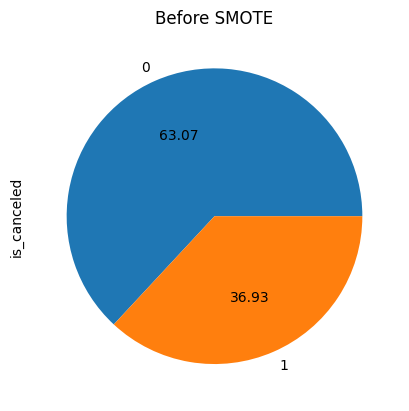

In [245]:
# Piechart sebelum
y_train.value_counts().plot.pie(autopct = '%.2f')
plt.title('Before SMOTE')
plt.show()

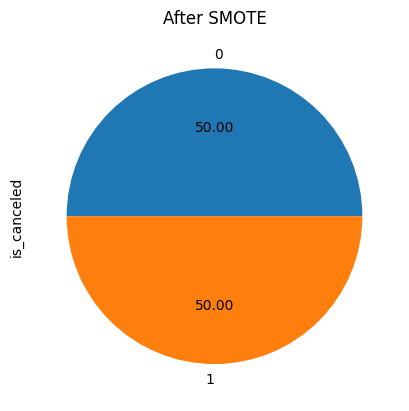

In [246]:
# Pie chart setelah SMOTE
y_train_smt.value_counts().plot.pie(autopct = '%.2f')
plt.title('After SMOTE')
plt.show()

Juga terlihat dimana ROS dan SMOTE sama-sama meningkatkan minority class agar sama dengan majority class, namun cara menambahkan datanya berbeda

### Combination (Oversampling & Undersampling)

Yang terakhir adalah resampling dengan combination dari oversampling dan undersampling

#### SMOTENN

In [247]:
# Fit dengan smotenn
x_train_smtnn, y_train_smtnn = smtnn.fit_resample(x_train_prep, y_train)

In [248]:
# awal data
y_train.value_counts()

0    41992
1    24585
Name: is_canceled, dtype: int64

In [249]:
# Setelah Smotenn
y_train_smtnn.value_counts()

0    23697
1    20289
Name: is_canceled, dtype: int64

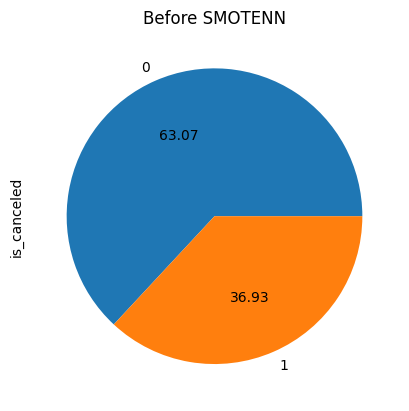

In [250]:
# piechart sebelum
y_train.value_counts().plot.pie(autopct = '%.2f')
plt.title('Before SMOTENN')
plt.show()

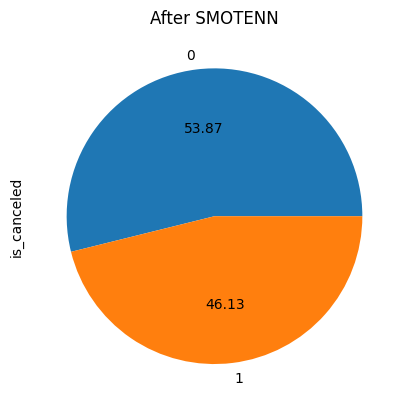

In [251]:
# piechart setelah smotenn
y_train_smtnn.value_counts().plot.pie(autopct = '%.2f')
plt.title('After SMOTENN')
plt.show()

Dimana kali ini merupakan kombinasi dari oversampling dan undersampling, dan terlihat bahwa hasil akhir tidak sepenuhnya balance (50:50), namun masih menyisakan sekitar 3% dari majority class

### Without Resampling

Sekarang kita akan compare performanya dengan menggunakan Pipeline dan memasukkan transformer dan modelnya

In [254]:
# membuat tanpa adanya resampling
estimator_without = Pipeline([
        ('transformer',transformer),
        ('model',model)
    ])

estimator_without.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('model', LGBMClassifier())])

In [255]:
# cross-val tanpa resampling
cv_without = cross_val_score(estimator_without, x_train, y_train, cv=skfold, scoring='f1')
print('Rata-rata score f1 tanpa resampling: {}'.format(cv_without.mean()))

Rata-rata score f1 tanpa resampling: 0.7285559799903099


### With Oversampling

#### RandomOverSampling

In [256]:
# pipeline dengan ROS
estimator_over = Pipeline([
        ('transformer',transformer),
        ('ros',ros),
        ('model',model)
    ])

estimator_over.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('ros',
                 RandomOverSampler(random_state=100,
                                   sampling_strategy='not majority')),
                ('model', LGBMClassifier())])

In [257]:
# cross-val dengan ROS
cv_over = cross_val_score(estimator_over, x_train, y_train, cv=skfold, scoring='f1')
print('Rata-rata score f1 dengan oversampling: {}'.format(cv_over.mean()))

Rata-rata score f1 dengan oversampling: 0.7399235905463385


#### SMOTE

In [258]:
# pipeline dengan SMOTE
estimator_smt = Pipeline([
        ('transformer',transformer),
        ('smote',smt),
        ('model',model)
    ])

estimator_smt.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('smote',
                 SMOTE(random_state=100, sampling_strategy='not majority')),
                ('model', LGBMClassifier())])

In [259]:
# Cross-val dengan SMOTE
cv_smt = cross_val_score(estimator_smt, x_train, y_train, cv=skfold, scoring='f1')
print('Rata-rata score f1 dengan smote: {}'.format(cv_over.mean()))

Rata-rata score f1 dengan smote: 0.7399235905463385


### With Undersampling

#### RandomUnderSampling

In [260]:
# Pipeline dengan RUS
estimator_under = Pipeline([
        ('transformer',transformer),
        ('rus',rus),
        ('model',model)
    ])

estimator_under.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('rus',
                 RandomUnderSampler(random_state=100,
                                    sampling_strategy='not minority')),
                ('model', LGBMClassifier())])

In [261]:
# cross-val dengan RUS
cv_under = cross_val_score(estimator_under, x_train, y_train, cv=skfold, scoring='f1')
print('Rata-rata score f1 dengan undersampling: {}'.format(cv_under.mean()))

Rata-rata score f1 dengan undersampling: 0.7389056320678609


#### NearMiss

In [262]:
# Pipeline dengan NearMiss
estimator_nm = Pipeline([
        ('transformer',transformer),
        ('NM',nm),
        ('model',model)
    ])

estimator_nm.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('NM', NearMiss(sampling_strategy='not minority')),
                ('model', LGBMClassifier())])

In [263]:
# Cross-val dengan NearMiss
cv_nm = cross_val_score(estimator_nm, x_train, y_train, cv=skfold, scoring='f1')
print('Rata-rata score f1 dengan nearmiss: {}'.format(cv_under.mean()))

Rata-rata score f1 dengan nearmiss: 0.7389056320678609


### With Combination Sampling

#### SMOTENN

In [264]:
# Pipeline dengan SMOTEENN
estimator_smtnn = Pipeline([
        ('transformer',transformer),
        ('SMOTENN',smtnn),
        ('model',model)
    ])

estimator_smtnn.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('SMOTENN', SMOTEENN(random_state=100)),
                ('model', LGBMClassifier())])

In [265]:
# cross-val dengan SMOTEENN
cv_smtnn = cross_val_score(estimator_smtnn, x_train, y_train, cv=skfold, scoring='f1')
print('Rata-rata score f1 dengan SMOTENN: {}'.format(cv_under.mean()))

Rata-rata score f1 dengan SMOTENN: 0.7389056320678609


Setelah mendapatkan hasil cross-val tiap metode resampling kita akan buatkan summarynya

### Summary

In [266]:
# buat datafram tiap iterasi dari cross-validation
summary = pd.DataFrame({'without':cv_without,'ROS':cv_over,'SMOTE':cv_smt,'RUS':cv_under,'NearMiss':cv_nm,'SMOTENN':cv_smtnn})
summary

,without,ROS,SMOTE,RUS,NearMiss,SMOTENN
0,0.726036,0.739235,0.738265,0.735460,0.702748,0.676345
1,0.724175,0.733409,0.733762,0.735031,0.704847,0.705164
2,0.731791,0.740549,0.738548,0.739736,0.711388,0.711583
3,0.737879,0.746929,0.741759,0.745439,0.723979,0.707525
4,0.722899,0.739496,0.739776,0.738861,0.700891,0.703938


In [267]:
# buatkan row baru dimana adalah average dari tiap column
summary = summary.append(summary.mean(axis=0),ignore_index=True)

In [268]:
# masukkan column calculation
summary['Calculation'] = ['iteration','iteration','iteration','iteration','iteration','Average']

In [269]:
# hasil akhir summary
summary

,without,ROS,SMOTE,RUS,NearMiss,SMOTENN,Calculation
0,0.726036,0.739235,0.738265,0.735460,0.702748,0.676345,iteration
1,0.724175,0.733409,0.733762,0.735031,0.704847,0.705164,iteration
2,0.731791,0.740549,0.738548,0.739736,0.711388,0.711583,iteration
3,0.737879,0.746929,0.741759,0.745439,0.723979,0.707525,iteration
4,0.722899,0.739496,0.739776,0.738861,0.700891,0.703938,iteration
5,0.728556,0.739924,0.738422,0.738906,0.708771,0.700911,Average


Berdasarkan hasil cross validasi, untuk menangani imbalance data, **RandomOverSampler** memiliki average yang paling tinggi, oleh karena itu kita akan menggunakan RandomOverSampler sebagai penanganan imbalance data kita.

Selanjutnya kita akan lihat bagaimana resampling akan mempengaruhi perubahan pada test set 

In [270]:
# fit data dengan ROS
aft_sampl = estimator_over.fit(x_train, y_train)

In [273]:
# predict x_test
y_pred = aft_sampl.predict(x_test)

In [274]:
# print classification report & roc auc
print(classification_report(y_test, y_pred))
print('ROC AUC Score:',roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     10498
           1       0.71      0.80      0.75      6147

    accuracy                           0.81     16645
   macro avg       0.79      0.80      0.80     16645
weighted avg       0.81      0.81      0.81     16645

ROC AUC Score: 0.8034352558047653


Tanpa Resampling:

model|Precision|Recall|f1-score|Accuracy|ROC_AUC
-----|------------|--------|--------|----------|------
LightGBM|0.777182|0.707012|0.740438|0.816942|0.794161

Terlihat bahwa precision mengalami penurunan namun pada recallnya naik cukup drastis, hal ini merupakan dampak dari oversampling, namun hal yang perlu di perhatikan bahwa penurunan pada precision lebih sedikit jika kita bandingkan dengan kenaikan dari recallnya, dan hal ini tentu membuat f1-score jadi lebih baik karena mean harmonicnya menjadi lebih besar. Selain itu, untuk accuracy tidak terlihat adanya perubahan yang besar, masih ada di angka 0.81, dan untuk roc auc juga terlihat adanya peningkatan yang cukup signifikan.

dari report diatas, menunjukkan bahwa melakukan resampling (lebih tepatnya lagi dengan RandomOverSampler) telah mengimprove performance dari model ini, oleh karena itu kita akan menggunakan RandomOverSampler di dalam pemodelan kita nanti

## Hyperparameter Tuning

Dalam tahapan hyperparameter tuning, pendekatan yang dilakukan yaitu dengan **bayesian optimization** dengan menggunakan library **optuna**

kita menggunakan **Bayesian Optimization** dengan alasan:
1. *Larger Scale*, dengan menggunakan bayesian optimization tuning, range dari tiap parameter lebih luas jangkauannya, hal ini dapat meningkatkan kesempatan untuk mendapatkan hidden layer yang tidak terdeteksi dibandingkan dengan menetapkan parameter secara manual dan paksa seperti **GridSearchCV**, selain itu Gridsearch memakan waktu yang lama jika dikombinasikan dengan parameter yang banyak, argumen parameter yang panjang dan juga cross-val yang foldnya banyak, oleh karena itu Bayesian Optimization dipilih berdasarkan hal hal itu

2. mengapa tidak RandomizedCV? Karena bayesian optimization justru merupakan bentuk lebih efisien dan lebih efektif dari RandomizedSearch, karena di randomized search kita secara acak mencari hyperparameter optimal, dan jika sudah ketemu kita akan melakukan adjustment dan lakukan Randomized search ulang, dan hal ini memakan waktu yang lama. dimana bayesian optimization sudah melakukan hal itu secara otomatis dari setiap trial yang dibuatnya, dimana dia akan melakukan adjustment dari trial yang lebih dulu terbuat untuk mengoptimisasi trial yang selanjutnya.

In [275]:
# buat function untuk melakukan trial
def objective(trial):
    # definisikan hyperparameter dari LightGBM
    model_param = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 1000),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # memasukkan kedalam model
    model = lgb.LGBMClassifier(**model_param) # ** untuk membuka dictionary

    # buatlah pipeline untuk fungsi ini
    pipeline = Pipeline([
        ('transformer', transformer), # transformer dan ros langsung di masukkan, karena merupakan global variable
        ('Resampling', ros),
        ('model', model)
    ])

    # evaluasi performance menggunakan cross-val
    scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='f1')
    # dari cros-val return mean dari 5 fold
    return np.mean(scores)

In [276]:
# membuat study dengan optuna, dimana tujuan untuk memaksimalkan nilai f-1 dengan pendekatan bayesian
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

# memanggil function objective diatas dan menggunakan trial 200 
study.optimize(objective, n_trials=200)

[I 2023-05-24 11:46:41,736] A new study created in memory with name: no-name-8d8c430f-493e-494a-96b6-6e5c4e11d212
[I 2023-05-24 11:46:54,094] Trial 0 finished with value: 0.731941422183501 and parameters: {'learning_rate': 0.06127925691239073, 'num_leaves': 4, 'max_depth': 479, 'n_estimators': 800, 'min_child_samples': 57, 'subsample': 0.7370630440860401, 'colsample_bytree': 0.13516500481723598, 'reg_alpha': 1.47515803163193e-08, 'reg_lambda': 0.2693178076741363}. Best is trial 0 with value: 0.731941422183501.
[I 2023-05-24 11:47:11,457] Trial 1 finished with value: 0.7408676371123402 and parameters: {'learning_rate': 0.45327615741043137, 'num_leaves': 76, 'max_depth': 582, 'n_estimators': 400, 'min_child_samples': 51, 'subsample': 0.37471466005124476, 'colsample_bytree': 0.482504127634085, 'reg_alpha': 0.4915113484365091, 'reg_lambda': 0.21770797563041372}. Best is trial 1 with value: 0.7408676371123402.
[I 2023-05-24 11:47:21,715] Trial 2 finished with value: 0.7404147596462062 and p

Berdasarkan study yang dilakukan optuna, yang terbaik ada pada trial 167 dengan score f1 = 0.7425495423019572

**Note:**
Hasil bisa berbeda jika di run ulang

Berikut default Hyperparameter dari LGBM:
1. `learning_rate` : 0.1
2. `num_leaves` : 31
3. `max_depth` : -1 (no limit)
4. `n_estimator` : 100
5. `min_child_samples` : 20
6. `subsample` : 1
7. `colsample_bytree` : 1
8. `reg_alpha` : 0
9. `reg_lambda`: 0

Sekarang kita lihat best parameternya

In [277]:
# masukkan best parameter dari study kedalam variable best_params
best_params = study.best_params
best_params

{'learning_rate': 0.09423927265469567,
 'num_leaves': 55,
 'max_depth': 638,
 'n_estimators': 250,
 'min_child_samples': 9,
 'subsample': 0.23542578360889393,
 'colsample_bytree': 0.6484849625386756,
 'reg_alpha': 7.97369994830372e-05,
 'reg_lambda': 1.8620897460681723e-05}

Terlihat bahwa tidak ada satupun dari parameternya yang menggunakan default hyperparameternya, hal ini karena scale yang cukup luas yang menimbulkan banyaknya hidden combination yang lebih preferable

Setelah kita melakukan hyperparameter tuning, kita akan compare apakah memang hyperparameter tuning telah mengimprove model kita atau tanpa hyperparameter tuning yang lebih baik

In [278]:
# buat model LGBM dengan best parameternya 
model = lgb.LGBMClassifier(**best_params) # ** untuk membuka dictionary
# buat pipeline best bs 
best_bs = Pipeline([
    ('transformer', transformer),
    ('Resampling', ros),
    ('model', model)
])

# fit pada data train
best_bs.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('Resampling',
                 RandomOverSampler(random_state=100,
                                   sampling_strategy='not majority')),
                ('model',
                 LGBMClassifier(colsample_bytree=0.6484849625386756,
                                learning_rate=0.09423927265469567,
                                max_depth=638, min_child_samples=9,
                                n_estimators=250, num_leaves=55,
                                reg_alpha=7.97369994830372e-05,
                                reg_lambda=1.8620897460681723e-05,
                                subsample=0.23542578360889393))])

In [279]:
# buat tanpa tuning
estimator = Pipeline([
    ('transformer',transformer),
    ('oversampling',ros),
    ('model',lgbm ) # disini menggunakan variable lgbm dimana merupakan model tanpa tuning parameter
    ])

# fit pada data train
estimator.fit(x_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('oversampling',
                 RandomOverSampler(random_state=100,
                                   sampling_strategy='not majority')),
                ('model', LGBMClassifier())])

In [280]:
# predict dengan tuning dan default
y_pred_default = estimator.predict(x_test)
y_pred_tuned = best_bs.predict(x_test)

In [281]:
# lihat hasil f1-score
f1_default = f1_score(y_test,y_pred_default)
f1_tuned = f1_score(y_test,y_pred_tuned)

print('F1 not tuned: ',f1_default)
print('F1 Tuned:',f1_tuned)

F1 not tuned:  0.7512846077153157
F1 Tuned: 0.7516596258298129


Terlihat walau hanya sedikit yang meningkat, namun ini membuktikan bahwa tuning model kita telah mengimprove model

Lalu kita akan lihat untuk metrics-metrics yang lainnya

In [282]:
# Classification report before & after tuning
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default : \n', report_default)
print('Classification Report Tuned : \n', report_tuned)

Classification Report Default : 
               precision    recall  f1-score   support

           0       0.87      0.81      0.84     10498
           1       0.71      0.80      0.75      6147

    accuracy                           0.81     16645
   macro avg       0.79      0.80      0.80     16645
weighted avg       0.81      0.81      0.81     16645

Classification Report Tuned : 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84     10498
           1       0.70      0.81      0.75      6147

    accuracy                           0.80     16645
   macro avg       0.79      0.80      0.79     16645
weighted avg       0.81      0.80      0.80     16645



Setelah tuning, kita lihat bahwa adanya trade-off antara precision dan recall, dan untuk f1-score masih sama karena peningkatannya tidak begitu signifikan, namun untuk accuracynya terlihat menurun, **namun** perlu diperhatikan bahwa accuracy pada titik ini merupakan metrics yang kurang tepat untuk digunakan dikarenakan data yang kita hadapi adalah data imbalance, walau sudah di resampling, accuracy bukanlah metrics yang tepat

dan tentunya kita juga perlu melihat roc aucnya

In [283]:
# ROC AUC before & after tuning
roc_auc_default = roc_auc_score(y_test,y_pred_default)
roc_auc_tuned = roc_auc_score(y_test,y_pred_tuned)

print('ROC/AUC not tuned: ',roc_auc_default)
print('ROC/AUC Tuned:',roc_auc_tuned)

ROC/AUC not tuned:  0.8034352558047653
ROC/AUC Tuned: 0.8039333171613128


terluhat bahwa roc auc juga meningkat walau hanya sedikit saja (sama seperti f1)

Konklusinya, walaupun dengan hyperparameter f1-score dan roc aucnya hanya sedikit lebih baik, tuning tersebut menunjukkan adanya peningkatan performa, walaupun dari sisi akurasi yang justru menurun, namun hal ini tidak bisa dijadikan benchmark, karena akurasi pada data imbalance merupakan metrics yang buruk atau kurang tepat untuk digunakan. oleh karena itu model yang kita gunakan adalah **model yang sudah di tuning hyperparameternya** 

## Feature Importance

Sekarang kita perlu tau untuk keperluan bisnis hotel ini kedepannya, sebenarnya feature apa saja yang memiliki tingkat pengaruh paling tinggi terhadap seorang/organisasi melakukan cancelation

In [284]:
# mengambil model dari best bs
model = best_bs.named_steps['model']

In [285]:
# extract feature importance
feature_imp_arr = model.feature_importances_
feature_imp_arr

array([ 105,   55,  128,  494,  507,   36,  305,  435,  589,  595,  837,
        750,  695,    0,  536,  428,  721,   88,  428,  749,  565,  612,
       1580, 1034,   80, 1148])

Terlihat masih dalam bentuk array, namun hal penting yang perlu diketahui adalah array ini mengeluarkan **sesuai dengan urutan**

selanjutnya kita akan ambil feature namesnya

In [286]:
# masukkan nama feature ke feature_names
feature_names = features 
feature_names

['deposit_type_Non Refund',
 'deposit_type_Refundable',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'country_0',
 'country_1',
 'country_2',
 'country_3',
 'country_4',
 'country_5',
 'country_6',
 'country_7',
 'market_segment_0',
 'market_segment_1',
 'market_segment_2',
 'market_segment_3',
 'reserved_room_type_0',
 'reserved_room_type_1',
 'reserved_room_type_2',
 'reserved_room_type_3',
 'previous_cancellations',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [287]:
# membuat series untuk score dan nama featurenya
arr_series = pd.Series(feature_imp_arr, name='Score')
list_series = pd.Series(feature_names, name='Feature')

In [288]:
# melakukan concat untuk menggabungkan kedalam 1 dataframe
feature_importance = pd.concat([arr_series, list_series], axis=1)
# sort berdasarkan score tertinggi dan ambil top 10nya
feature_importance_plot = feature_importance.sort_values(by='Score',ascending=False).head(10)

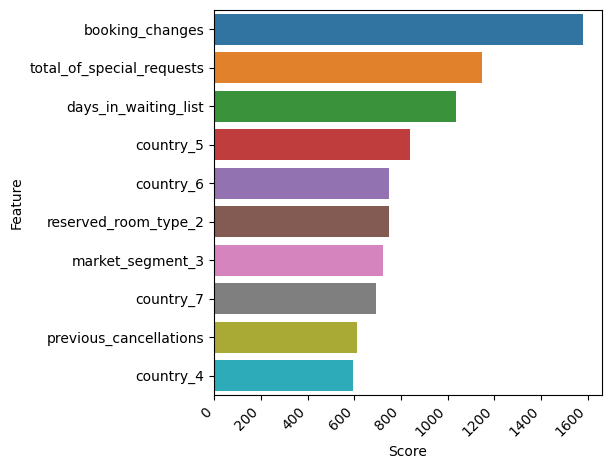

In [289]:
# plot dari feature importance plot
plt.figure(figsize=(5,5))
sns.barplot(feature_importance_plot, y='Feature',x='Score')
plt.xticks(rotation=45, ha='right')
plt.show()

Dari barplot diatas menunjukkan bahwa `booking change` adalah feature yang paling berpengaruh terhadap target variable, yaitu apakah customer akan cancel atau tidak, diikuti juga dengan `total special request` dan `days in waiting list`. 

tentu untuk `booking change` ini sangat masuk akal dimana jika sering terjadinya perubahan pada booking akan berdampak kepada ketidak pastian, dan juga untuk `special request`, dimana banyaknya request yang diminta customer menunjukkan kebutuhan utama dari customer tersebut untuk menginap di hotel ini, dan untuk `days in waiting list` menunjukkan berapa lama customer itu akan menunggu untuk mendapatkan kamarnya, semakin lama antriannya semakin sedikit customer akan mempertahankan dirinya dalam list tersebut

# Conclusion & Recommendation

## Conclusion

In [290]:
# Hasil report model terakhir
print('Classification Report Tuned : \n', report_tuned)
print('ROC/AUC Tuned:',roc_auc_tuned)

Classification Report Tuned : 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84     10498
           1       0.70      0.81      0.75      6147

    accuracy                           0.80     16645
   macro avg       0.79      0.80      0.79     16645
weighted avg       0.81      0.80      0.80     16645

ROC/AUC Tuned: 0.8039333171613128


Classification report yang akan menjadi final model adalah yang di tuning seperti diatas, dan menurut classification report diatas bahwa model ini akan digunakan oleh hotel baik dari bagian marketing ataupun management untuk memprediksi terjadinya cancelation dari customer. Dan berdasarkan model ini menunjukkan bahwa:

1. Dari seluruh customer yang akan cancel maka sekitar 81% diprediksi dengan benar menggunakan model ini, hal ini bisa dilihat dari recallnya pada target 1 (cancel), dan model juga dapat menebak dengan benar untuk customer yang tidak melakukan cancel sebesar 80% dari seluruh customer yang memang tidak cancel, hal ini juga dilihat dati recall dari target 0 (not cancel). 

2. Dari seluruh prediksi cancel dari model, model dapat mengidentifikasi sekitar 70% ketepatan prediksi target 1 (cancel) hal ini diambil dari precisionnya, dan dari seluruh prediksi bahwa customer tidak akan cancel akan diidentifikasi benar oleh model sekitar 88% pada target 0(tidak cancel) hal ini juga diambil dari precisionnya

Lalu bagaimana hal ini akan membantu hotel dalam meningkatkan profitablitas atau mengurangi revenue loss? kita akan berikan ilustrasi dengan menggunakan test data, dimana pada test data terdapat:

1. 6147 customer akan cancel
2. 10498 customer tidak akan cancel

Disini kita akan mengambil **scenario yang pertama**, yaitu tanpa menggunakan model dan menganggap seluruh customer akan melakukan booking tanpa ada cancel, artinya akan ada **16645** customer yang melakukan booking pada hotel, dan dengan anggapan hotel mengambil keuntungan dari kamar sebesar 70% dimana harga rata-rata kamar di portugal sekitar 85 USD (dilansir dari [sini](https://www.budgetyourtrip.com/hotels/portugal-PT#:~:text=The%20average%20hotel%20price%20in,days%20in%20Portugal%20is%20%24296.)), maka keuntungannya bisa 60 USD per kamar. Maka dari itu **skenario pertamanya**,

**Skenario Tanpa Model** :

1. Menerima seluruh booking, maka ekspetasi keuntungan diawal:<br>
16.645 Books X 60 USD = 998.700 USD
2. Customer yang ternyata cancel = 6.147 Cancel X 60 USD = 368.820 USD
3. Total Revenue Loss = **368.820 USD**
4. Net profit = **629.880 USD**

Terlihat pada skenario pertama jika tidak menggunakan model, dan secara besar-besaran menerima seluruh customer yang melakukan booking, maka revenue loss akan menjadi 368.820 USD dan net profitnya 629.880 USD, dimana tidak ada tindakan resource allocation, dimana langsung mengisi kamar yang terprediksi cancel dengan yang di prediksi tidak cancel.

**Skenario Dengan Model :**

Jika dengan model, kita akan lihat hasil prediksinya dengan lebih detail menggunakan Confusion Matrix: 

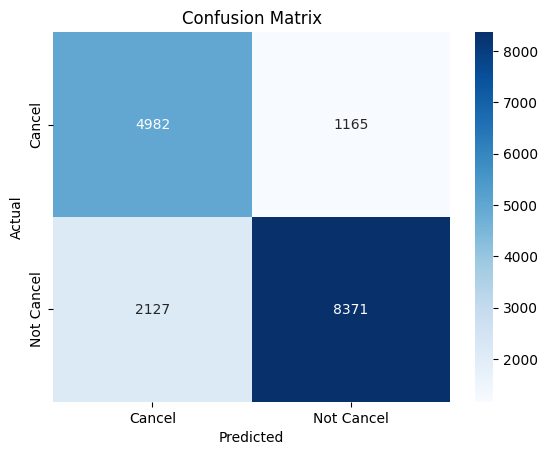

In [291]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)

# Reorder the confusion matrix
cm_reordered = cm[::-1, ::-1]

# Create a heatmap of the reordered confusion matrix
ax = sns.heatmap(cm_reordered, annot=True, fmt="d", cmap="Blues")

# Set the tick labels for x-axis and y-axis
ax.set_xticklabels(["Cancel", "Not Cancel"])
ax.set_yticklabels(["Cancel", "Not Cancel"])

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

Dapat digambarkan seperti ini:

TP |FN
---|---
FP |TN

Jika hotel sudah menjadikan data untuk membuat keputusan dan juga sudah menggunakan otomasi dari data (dimana hotel sudah *Data-Driven*), maka hotel sudah mempersiapkan langkah **Resource Allocation**, Dimana hotel tidak akan menyia-nyiakan kamar yang sudah terprediksi akan cancel, melainkan hotel tersebut akan mencari penggantinya dimana penggantinya juga akan diperlakukan model prediction untuk menentukan apakah penggantinya benar-benar tidak cancel atau tidak, maka dari ini skenarionya akan seperti ini:

1. Menerima seluruh booking dengan prediksi tidak cancel:<br>
8.371(Benar-Benar tidak cancel) + 1.165(kesalahan model dalam memprediksi) = 9.536 Booking<br>
Keuntungan nett dari hasil prediksi tidak cancel = 8374 Book X 60 USD = 502.260 USD<br>
Salah prediksi = 1165 Book X 60 USD = 69.900 USD


2. Melakukan **Resource Allocation** dari yang terprediksi cancel =<br>
4982 (benar-benar cancel) + 2.127 (Terprediksi cancel padahal tidak cancel) = 7.109 Booking<br>
Melakukan **Resource Allocation** dengan menggunakan model,
**Akan ada 88% yang terprediksi tidak cancel dari pengganti terprediksi cancel** (Hal ini berdasarkan precision dari 0),<br>
Maka... akan dilakukan prioritas untuk terprediksi tidak cancel sebanyak 7.109 booking, maka hitungan akan benar-benar tidak<br>
cancel adalah:
Alokasi ke bookingan baru dengan prediksi tidak cancel sebanyak 7.109, dengan ketepatan 88%<br>
Yang benar-benar tidak cancel = 7.109 X 88% = 6.256 Bookings X 60 USD = 375.360 USD<br>
Yang ternyata cancel = 7.109 - 6.256 = 853 Bookings X 60 USD = 51.180 USD

3. 
- True Negative = 502.260 USD (Revenue)
- False Negative = 69.900 USD (Revenue Loss)
- Alokasi pada seluruh kelas positive dan digantikan dengan kelas negatif:<br>
    - True Negative hasil alokasi dari positive class = 375.360 USD (Revenue/ Berdasarkan precision target 0)
    - False Negative hasil alokasi dari positive class = 51.180 USD (Revenue Loss)

Total dengan menggunakan model:
Net Profit = **877.620 USD**<br>
Dengan total Revenue Loss = **121.080 USD**


**Konklusi dari Perbandingan**,

Perhitungan|Tanpa model|Dengan Model 
-----------|-----------|-----------
Total Revenue Loss| **368.820 USD**|**121.080 USD**
Net profit  |**629.880 USD**|**877.620 USD**

Terlihat dengan model, hotel akan mengimplementasikan **Resource Allocation** dimana hal itu secara signifikan sangat meningkatkan net profit dan juga mengurangi total revenue lossnya.

Oleh karena itu penggunaan model untuk memprediksi bisa sangat membantu hotel portugal ini untuk meningkatkan keuntungan dan juga pastinya mengurangi potensi hilangnnya keuntungan.


**IMPORTANT NOTE:**

**JIKA MODEL DI RUN ULANG DARI AWAL, BISA TERJADI PERUBAHAN PADA HASIL CONFUSION MATRIX (WALAU TIDAK BANYAK), HAL INI DISEBABKAN OLEH HYPERPARAMETER TUNING YANG DIGUNAKAN DENGAN MEMGGUNAKAN BAYESIAN OPTIMIZATION**

## Recommendation

1. Datanya cukup terbatas, setiap kolom juga memiliki limitnya masing-masing, model ini kurang di percaya jika model digunakan untuk memprediksi data yang melewati batas, ataupun jika ada kolom baru yang belum pernah di trainingkan di dalam model ini

2. Bisa terjadinya bias, walaupun hasil akhir dari model menghasilkan hasil yang bagus dan juga cukup berpengaruh untuk menyelesaikan permasalahan di hotel, hal ini bisa terjadi karena keberadaan dari duplikat yang cukup banyak. namun seperti yang sudah di sampaikan di atas bahwa duplikat tersebut memang membawa banyak informasi penting, namun perlu di perhatikan bahwa nature dari duplikat itu sendiri membawakan bias pada data.

3. Penambahan area training, dimana menambahkan kolom yang mungkin akan lebih relevan seperti "berapa hari menginap" atau "harga kamar yang di sewakan" bisa membantu untuk meningkatkan model agar model memiliki performa yang lebih akurat 

4. Jika sudah menggunakan model ini untuk melakukan business decision, akan lebih baik dengan mengimplementasi **Resource Allocation**, dimana seperti yang di sampaikan pada bagian **Conclusion**, namun perlu diingat ada kalanya model tidak bisa dipercaya, maka pada momen itu lebih baik menggunakan cara seperti biasanya

5. Walaupun sudah dilakukan model benchmarking, bisa lebih baik lagi dengan model-model yang belum teruji disini, bisa saja dengan model yang belum pernah teruji disini bisa melebihi performa dari model yang sekarang 

6. Improvement of data quality, dimana disini qualitas datanya masih kurang maksimal (Duplicates sampai 70% data), sehingga cara membersihkan data menjadi cara yang *uncertain* dan tidak ada cara-cara lain selain menetapkan informasi tersebut kedalam data.

# Saving model : Pickle

Tentu pada tahap akhir kita perlu menyimpan model ini dengan menggunakan pickle, dimana nantinya model kita bisa digunakan untuk melakukan prediksi 

In [292]:
# Saving model
filename = 'Cancellation Hotel Booking Model.sav'
pickle.dump(best_bs, open(filename, 'wb'))